[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_07_descenso_gradiente-published.ipynb)

# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [2]:
bias = 500
X, y, coef = make_regression(n_samples=5000, 
                             n_features=3, 
                             bias= bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" + 
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" + 
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (np.float64(113.11), np.float64(865.44))
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

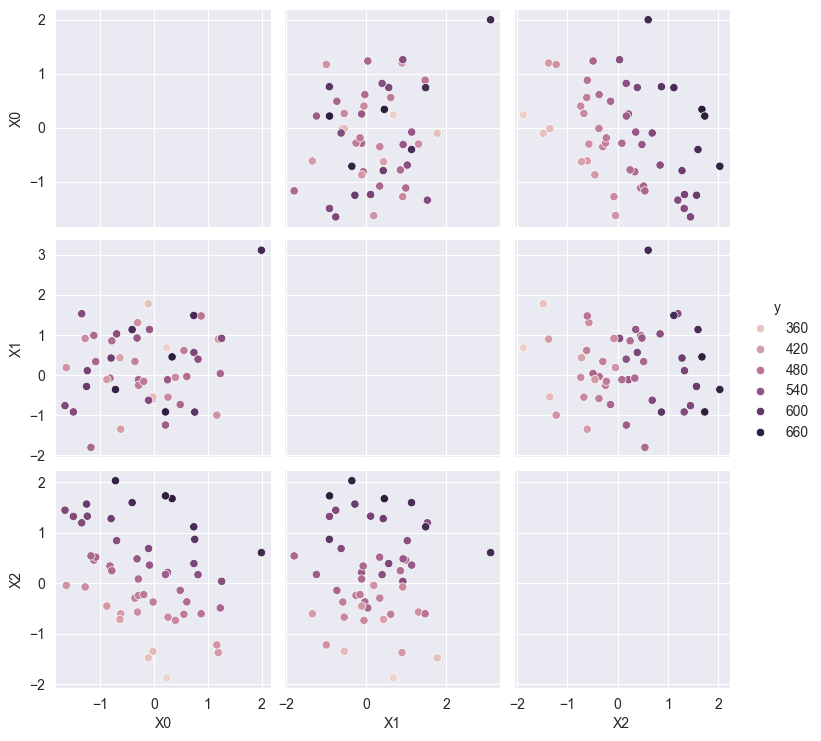

In [3]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [4]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    
    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [5]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [6]:
def descenso_gradiente(g, dg, z_init, alpha, num_iterations, tol, verbose=False):
    """
    Descenso de gradiente para minimizar g. 
    Args:
        g: La función a optimizar. 
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia. 
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [7]:
from sklearn import preprocessing
from functools import partial

class RegresionLinealDG():
    
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray], 
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False
   
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)       
                    
        w_shape = X_train_ext.shape[1]
        self.w = descenso_gradiente(cost_X_y, grad_cost_X_y, 
                        z_init=np.zeros(w_shape), 
                        **self.descenso_gradiente_hyperparams)


Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [8]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)
 
def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [9]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)

Entrenarla:

In [10]:
reg.fit(X,y)

Y obtener los w 

In [11]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.5  38.9   1.5  89.7]


In [12]:
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [13]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [14]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados


(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}` 
    
    y reportar su comportamiento.

1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.
1. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.


In [15]:
# aux
def run_experiment(func_costo: Callable[..., float], 
                   func_costo_grad: Callable[..., np.ndarray], 
                   hyperparametros: Dict[str, Any], 
                   X: np.ndarray, 
                   y: np.ndarray, 
                   resultados: pd.DataFrame, 
                   nombre: str,
                   hyperparam_name: str) -> pd.DataFrame:
    reg = RegresionLinealDG(func_costo, func_costo_grad, hyperparametros)
    reg.fit(X,y)
    print(f"({nombre}) w", reg.w.round(1))
    err = error_prediccion(X, y, reg.w)
    resultados.loc[len(resultados)] = [f"{nombre} {hyperparam_name}:{hyperparametros[hyperparam_name]}"] + list(reg.w) + [err]
    return resultados

In [16]:
# Ejercicio 1
# Realizar una grilla para los hyperparámetros de la regresión: {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01} y reportar su comportamiento.

# TODO ¿se refiere a hacer un grid search para encontrar los mejores hiperparámetros? no entendí bien



In [17]:
# Ejercicio 2
# Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre: MSE_Ridge, MSE_Lasso, MSE_ElasticSearch

def mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float = 0.01) -> float:
    y_preds = X @ w
    return mse(w, X, y) + alpha * np.sum(w**2)

def grad_mse_ridge(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float = 0.01) -> np.ndarray:
    return grad_mse(w, X, y) + 2 * alpha * w

run_experiment(mse_ridge, grad_mse_ridge, {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteRidge", "alpha")

resultados

(DescensoGradienteRidge) w [494.6  38.5   1.5  88.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteRidge alpha:0.01,494.590734,38.485574,1.496163,88.815846,31.679483


In [18]:
# pruebo otros alpha
alphas = [0.001, 0.1]
for alpha in alphas:
    run_experiment(mse_ridge, grad_mse_ridge, {"alpha": alpha, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteRidge", "alpha")

(DescensoGradienteRidge) w [429.6  32.5   1.9  76.8]
(DescensoGradienteRidge) w [494.9  38.5   1.5  88.9]


In [19]:
# Set the display option to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteRidge alpha:0.01,494.590734,38.485574,1.496163,88.815846,31.679483
4,DescensoGradienteRidge alpha:0.001,429.561195,32.506103,1.889827,76.797094,5171.815958
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725


In [20]:
# pruebo otras iteraciones
num_iterations = [10000, 100000]
for n in num_iterations:
    run_experiment(mse_ridge, grad_mse_ridge, {"alpha": 0.01, "num_iterations": n, "tol": 0.01}, X, y, resultados, "DescensoGradienteRidge", "num_iterations")

(DescensoGradienteRidge) w [494.6  38.5   1.5  88.8]
(DescensoGradienteRidge) w [494.6  38.5   1.5  88.8]


In [21]:
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteRidge alpha:0.01,494.590734,38.485574,1.496163,88.815846,31.679483
4,DescensoGradienteRidge alpha:0.001,429.561195,32.506103,1.889827,76.797094,5171.815958
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
6,DescensoGradienteRidge num_iterations:10000,494.590734,38.485574,1.496163,88.815846,31.679483
7,DescensoGradienteRidge num_iterations:100000,494.590734,38.485574,1.496163,88.815846,31.679483


In [22]:
def mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float = 0.01) -> float:
    return mse(w, X, y) + alpha * np.sum(np.abs(w))

def grad_mse_lasso(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float = 0.01) -> np.ndarray:
    return grad_mse(w, X, y) + alpha * np.sign(w)

run_experiment(mse_lasso, grad_mse_lasso, {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteLasso", "alpha")

(DescensoGradienteLasso) w [499.5  38.9   1.5  89.7]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteRidge alpha:0.01,494.590734,38.485574,1.496163,88.815846,31.679483
4,DescensoGradienteRidge alpha:0.001,429.561195,32.506103,1.889827,76.797094,5171.815958
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
6,DescensoGradienteRidge num_iterations:10000,494.590734,38.485574,1.496163,88.815846,31.679483
7,DescensoGradienteRidge num_iterations:100000,494.590734,38.485574,1.496163,88.815846,31.679483
8,DescensoGradienteLasso alpha:0.01,499.526249,38.899797,1.483721,89.710793,1.258495


In [23]:
def mse_elastic_search(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float = 0.01, beta: float = 0.01) -> float:
    return mse(w, X, y) + alpha * np.sum(w**2) + beta * np.sum(np.abs(w))

def grad_mse_elastic_search(w: np.ndarray, X: np.ndarray, y: np.ndarray, alpha: float = 0.01, beta: float = 0.01) -> np.ndarray:
    return grad_mse(w, X, y) + 2 * alpha * w + beta * np.sign(w)

run_experiment(mse_elastic_search, grad_mse_elastic_search, {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteElasticSearch", "alpha")

(DescensoGradienteElasticSearch) w [494.6  38.5   1.5  88.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteRidge alpha:0.01,494.590734,38.485574,1.496163,88.815846,31.679483
4,DescensoGradienteRidge alpha:0.001,429.561195,32.506103,1.889827,76.797094,5171.815958
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
6,DescensoGradienteRidge num_iterations:10000,494.590734,38.485574,1.496163,88.815846,31.679483
7,DescensoGradienteRidge num_iterations:100000,494.590734,38.485574,1.496163,88.815846,31.679483
8,DescensoGradienteLasso alpha:0.01,499.526249,38.899797,1.483721,89.710793,1.258495
9,DescensoGradienteElasticSearch alpha:0.01,494.585818,38.480429,1.491289,88.810683,31.747731


In [24]:
# Ejercicio 3
# Modificar RegresionLinealDG para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.

class RegresionLinealDGMiniBatch(RegresionLinealDG):
    def __init__(self,
                 func_costo: Callable[..., float], 
                 func_costo_grad: Callable[..., np.ndarray], 
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None,
                 epochs: int = 100,
                 batch_size: int = 32):
        super().__init__(func_costo, func_costo_grad, descenso_gradiente_hyperparams)
        self.epochs = epochs
        self.batch_size = batch_size
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:        
        col_ones = np.ones((X.shape[0], 1))
        X_train_ext = np.hstack((col_ones, X))

        cost_X_y = partial(self.func_costo, X=X_train_ext, y=y)
        grad_cost_X_y = partial(self.func_costo_grad, X=X_train_ext, y=y)       
                    
        w_shape = X_train_ext.shape[1]
        self.w = np.zeros(w_shape)
        
        for i in range(self.epochs):
            X_iter = X_train_ext.copy()
            y_iter = y.copy()
            # while there are enough samples to form a batch
            while X_iter.shape[0] >= self.batch_size:
                idx = np.random.choice(X_iter.shape[0], self.batch_size, replace=False)
                X_batch = X_iter[idx]
                y_batch = y_iter[idx]
                gradient = grad_cost_X_y(self.w)
                self.w = self.w - self.descenso_gradiente_hyperparams["alpha"] * gradient
                X_iter = np.delete(X_iter, idx, axis=0)
                y_iter = np.delete(y_iter, idx)
        

In [25]:
# aux
def run_experiment_mini_batch(func_costo: Callable[..., float], 
                   func_costo_grad: Callable[..., np.ndarray], 
                   hyperparametros: Dict[str, Any], 
                   X: np.ndarray, 
                   y: np.ndarray, 
                   resultados: pd.DataFrame, 
                   nombre: str,
                   hyperparam_name: str,
                   batch_size: int = 32,
                   epochs: int = 100) -> pd.DataFrame:
    reg = RegresionLinealDGMiniBatch(func_costo, func_costo_grad, hyperparametros, batch_size=batch_size, epochs=epochs)
    reg.fit(X,y)
    print(f"({nombre}) w", reg.w.round(1))
    err = error_prediccion(X, y, reg.w)
    resultados.loc[len(resultados)] = [f"{nombre} [MB] {hyperparam_name}:{hyperparametros[hyperparam_name]}"] + list(reg.w) + [err]
    return resultados

In [26]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

# vuelvo a correr "los mejores" con mini-batch

# DescensoGradiente 1000 iteraciones
run_experiment_mini_batch(mse, grad_mse, hyperparametros, X, y, resultados, "DescensoGradiente [32]", "num_iterations")

# DescensoGradienteRidge alpha:0.1
run_experiment_mini_batch(mse_ridge, grad_mse_ridge, {"alpha": 0.1, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteRidge [32]", "alpha")

# DescensoGradienteLasso alpha:0.01
run_experiment_mini_batch(mse_lasso, grad_mse_lasso, hyperparametros, X, y, resultados, "DescensoGradienteLasso [32]", "alpha")

(DescensoGradiente [32]) w [500.   39.    1.5  89.8]
(DescensoGradienteRidge [32]) w [495.1  38.5   1.5  88.9]
(DescensoGradienteLasso [32]) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
3,DescensoGradienteRidge alpha:0.01,494.590734,38.485574,1.496163,88.815846,31.679483
4,DescensoGradienteRidge alpha:0.001,429.561195,32.506103,1.889827,76.797094,5171.815958
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
6,DescensoGradienteRidge num_iterations:10000,494.590734,38.485574,1.496163,88.815846,31.679483
7,DescensoGradienteRidge num_iterations:100000,494.590734,38.485574,1.496163,88.815846,31.679483
8,DescensoGradienteLasso alpha:0.01,499.526249,38.899797,1.483721,89.710793,1.258495
9,DescensoGradienteElasticSearch alpha:0.01,494.585818,38.480429,1.491289,88.810683,31.747731


In [27]:
resultados.sort_values("error_prediccion")

,metodo,w0,w1,w2,w3,error_prediccion
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
10,DescensoGradiente [32] [MB] num_iterations:1000,500.019873,38.968244,1.475379,89.815231,0.999661
12,DescensoGradienteLasso [32] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
8,DescensoGradienteLasso alpha:0.01,499.526249,38.899797,1.483721,89.710793,1.258495
11,DescensoGradienteRidge [32] [MB] alpha:0.1,495.070326,38.547391,1.483274,88.913080,26.467641
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
6,DescensoGradienteRidge num_iterations:10000,494.590734,38.485574,1.496163,88.815846,31.679483
7,DescensoGradienteRidge num_iterations:100000,494.590734,38.485574,1.496163,88.815846,31.679483


In [28]:
# mini-batch es menos preciso, imagino que al tener un dataset muy grande la velocidad con la cuál corre y el control sobre el tamaño del batch y los epochs puede ser útil

In [29]:
# borro todos los que no volví a correr con mini-batch
# DescensoGradienteRidge alpha:0.001, DescensoGradienteRidge alpha:0.01, DescensoGradienteRidge num_iterations:10000, DescensoGradienteRidge num_iterations:100000, DescensoGradienteElasticSearch alpha:0.01
to_delete = ["DescensoGradienteRidge alpha:0.001", "DescensoGradienteRidge alpha:0.01", "DescensoGradienteRidge num_iterations:10000", "DescensoGradienteRidge num_iterations:100000", "DescensoGradienteElasticSearch alpha:0.01"]
resultados = resultados[~resultados["metodo"].isin(to_delete)]

In [30]:
# batch size = 1

# DescensoGradiente 1000 iteraciones
run_experiment_mini_batch(mse, grad_mse, hyperparametros, X, y, resultados, "DescensoGradiente [1]", "num_iterations", batch_size=1)

# DescensoGradienteRidge alpha:0.1
run_experiment_mini_batch(mse_ridge, grad_mse_ridge, {"alpha": 0.1, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteRidge [1]", "alpha", batch_size=1)

# DescensoGradienteLasso alpha:0.01
run_experiment_mini_batch(mse_lasso, grad_mse_lasso, hyperparametros, X, y, resultados, "DescensoGradienteLasso [1]", "alpha", batch_size=1)

(DescensoGradiente [1]) w [500.   39.    1.5  89.8]
(DescensoGradienteRidge [1]) w [495.1  38.5   1.5  88.9]
(DescensoGradienteLasso [1]) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
8,DescensoGradienteLasso [1] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762
10,DescensoGradiente [32] [MB] num_iterations:1000,500.019873,38.968244,1.475379,89.815231,0.999661
11,DescensoGradienteRidge [32] [MB] alpha:0.1,495.070326,38.547391,1.483274,88.913080,26.467641
12,DescensoGradienteLasso [32] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762


In [31]:
# batch = 10% del dataset
batch_size = int(X.shape[0] * 0.1)
print(f"batch_size: {batch_size}")

# DescensoGradiente 1000 iteraciones
run_experiment_mini_batch(mse, grad_mse, hyperparametros, X, y, resultados, "DescensoGradiente [10%]", "num_iterations", batch_size=batch_size)

# DescensoGradienteRidge alpha:0.1
run_experiment_mini_batch(mse_ridge, grad_mse_ridge, {"alpha": 0.1, "num_iterations": 1000, "tol": 0.01}, X, y, resultados, "DescensoGradienteRidge [10%]", "alpha", batch_size=batch_size)

# DescensoGradienteLasso alpha:0.01
run_experiment_mini_batch(mse_lasso, grad_mse_lasso, hyperparametros, X, y, resultados, "DescensoGradienteLasso [10%]", "alpha", batch_size=batch_size)

batch_size: 500
(DescensoGradiente [10%]) w [500.   39.    1.5  89.8]
(DescensoGradienteRidge [10%]) w [495.1  38.5   1.5  88.9]
(DescensoGradienteLasso [10%]) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
8,DescensoGradienteLasso [10%] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762
10,DescensoGradiente [32] [MB] num_iterations:1000,500.019873,38.968244,1.475379,89.815231,0.999661
11,DescensoGradienteRidge [32] [MB] alpha:0.1,495.070326,38.547391,1.483274,88.913080,26.467641
12,DescensoGradienteLasso [32] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762


In [32]:
resultados.sort_values(["metodo", "error_prediccion"])

,metodo,w0,w1,w2,w3,error_prediccion
2,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
10,DescensoGradiente [32] [MB] num_iterations:1000,500.019873,38.968244,1.475379,89.815231,0.999661
8,DescensoGradienteLasso [10%] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762
12,DescensoGradienteLasso [32] [MB] alpha:0.01,500.014904,38.963038,1.470452,89.810007,0.999762
11,DescensoGradienteRidge [32] [MB] alpha:0.1,495.070326,38.547391,1.483274,88.913080,26.467641
5,DescensoGradienteRidge alpha:0.1,494.923713,38.526131,1.488387,88.881994,28.013725
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549


In [33]:
# Obtengo el método con los Ws más parecidos a descenso gradiente sin mini-batch (DescensoGradiente 1000)
# me quedo solo con los que tienen "DescensoGradiente" en el nombre como palabra completa 
descenso_gradiente_df = resultados[resultados["metodo"].str.contains(r"\bDescensoGradiente\b")]
descenso_gradiente_df
# calculo las diferencias en los Ws
descenso_gradiente_df["diff_w0"] = descenso_gradiente_df["w0"] - descenso_gradiente_df["w0"].iloc[0]
descenso_gradiente_df["diff_w1"] = descenso_gradiente_df["w1"] - descenso_gradiente_df["w1"].iloc[0]
descenso_gradiente_df["diff_w2"] = descenso_gradiente_df["w2"] - descenso_gradiente_df["w2"].iloc[0]
descenso_gradiente_df["diff_w3"] = descenso_gradiente_df["w3"] - descenso_gradiente_df["w3"].iloc[0]
descenso_gradiente_df

/tmp/ipykernel_469056/4246069956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descenso_gradiente_df["diff_w0"] = descenso_gradiente_df["w0"] - descenso_gradiente_df["w0"].iloc[0]
/tmp/ipykernel_469056/4246069956.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descenso_gradiente_df["diff_w1"] = descenso_gradiente_df["w1"] - descenso_gradiente_df["w1"].iloc[0]
/tmp/ipykernel_469056/4246069956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,metodo,w0,w1,w2,w3,error_prediccion,diff_w0,diff_w1,diff_w2,diff_w3
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022,0.000000,0.000000,0.000000,0.000000
10,DescensoGradiente [32] [MB] num_iterations:1000,500.019873,38.968244,1.475379,89.815231,0.999661,0.488660,0.063248,-0.013265,0.099221
